In [1]:
import sys
sys.path.insert(0, '/mnt/home/mlee1/vdm_BIND')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from bind.workflow_utils import ConfigLoader, ModelManager, sample
from vdm.astro_dataset import get_astro_data
from analysis.paper_utils import setup_plotting_style

setup_plotting_style()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda


## 1. Define Models to Compare

Each model needs a config file path. The `ConfigLoader` finds the best checkpoint automatically.

In [7]:
# Model configurations: {display_name: config_path}
MODELS = {
    'VDM': '/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_aggressive_stellar.ini',
    'Triple VDM': '/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini',
    'DDPM': '/mnt/home/mlee1/vdm_BIND/configs/ddpm.ini',
    'Interpolant': '/mnt/home/mlee1/vdm_BIND/configs/interpolant.ini',
    'Stochastic Interpolant': '/mnt/home/mlee1/vdm_BIND/configs/stochastic_interpolant.ini',
    'DSM': '/mnt/home/mlee1/vdm_BIND/configs/dsm.ini',
    'Consistency Model': '/mnt/home/mlee1/vdm_BIND/configs/consistency.ini',
    'OT Flow': '/mnt/home/mlee1/vdm_BIND/configs/ot_flow.ini',
}

CHANNEL_NAMES = ['Hydro DM', 'Gas', 'Stars']

## 2. Load Test Data

In [8]:
# Load one batch from test set
test_root = '/mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/test/'
datamodule = get_astro_data('IllustrisTNG', test_root, batch_size=4, num_workers=4, stage='test', quantile_path ='/mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl')
datamodule.setup(stage='test')
test_batch = next(iter(datamodule.test_dataloader()))

# Extract components: condition, target, large-scale maps, params
conditions, large_scale_maps,targets, params = test_batch
print(f"Condition: {conditions.shape}, Target: {targets.shape}, Large-scale: {large_scale_maps.shape}")

✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
📂 Loading file list from

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Condition: torch.Size([1, 1, 128, 128]), Target: torch.Size([1, 3, 128, 128]), Large-scale: torch.Size([1, 3, 128, 128])


## 3. Load Models & Generate Samples

In [9]:
# Select one halo for comparison
IDX = 0
cond = conditions[IDX:IDX+1]  # (1, 1, H, W)
large_scale = large_scale_maps[IDX:IDX+1]  # (1, 3, H, W)
target = targets[IDX]  # (3, H, W)
param = params[IDX:IDX+1]  # (1, N)

# Full conditioning = DM + large-scale context
full_cond = torch.cat([cond, large_scale], dim=1)  # (1, 4, H, W)

# Store samples from each model
samples = {}

In [10]:
# Load each model and generate a sample
for name, config_path in MODELS.items():
    if not Path(config_path).exists():
        print(f"⚠️ Skipping {name}: config not found")
        continue
    
    try:
        print(f"\n{'='*50}\nLoading {name}...")
        config = ConfigLoader(config_path, verbose=False)
        
        if config.best_ckpt is None:
            print(f"⚠️ Skipping {name}: no checkpoint found")
            continue
        
        _, model = ModelManager.initialize(config, verbose=False, skip_data_loading=True)
        model = model.to(DEVICE).eval()
        
        # Generate sample
        with torch.no_grad():
            s = sample(model, full_cond, batch_size=1, conditional_params=param.numpy())
            samples[name] = s[0, 0].cpu().numpy()  # (3, H, W)
        
        print(f"✓ {name} loaded and sampled")
        del model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")


Loading VDM...


Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-13.3, 13.0]
  Data noise (per-channel): (0.0005, 0.0005, 0.0005)
  Loss weights (diffusion, latent, recons): 1.0, 1.0, 1.0

🎯 CHANNEL WEIGHTS: (1, 1, 1)

✓ Parameter prediction enabled (weight=0.01)


✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING

Generating Samples (250 steps): 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
Seed set to 42

Seed set to 42


✓ VDM loaded and sampled

Loading Triple VDM...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNor

Generating Samples (250 steps): 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]
Seed set to 8

Seed set to 8


✓ Triple VDM loaded and sampled

Loading DDPM...


Sampling from the prior | t = 0.0 | sigma = 2.4e-02| scale ~ 2.2e+00: 100%|██████████| 250/250 [00:05<00:00, 48.09it/s]
Sampling from the prior | t = 0.0 | sigma = 2.4e-02| scale ~ 2.2e+00: 100%|██████████| 250/250 [00:05<00:00, 48.09it/s]
Generating Samples (250 steps): 100%|██████████| 1/1 [00:05<00:00,  5.21s/it]
Seed set to 8

Seed set to 8


✓ DDPM loaded and sampled

Loading Interpolant...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupN

Generating Samples (50 steps): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
Seed set to 8

Seed set to 8


✓ Interpolant loaded and sampled

Loading Stochastic Interpolant...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder ch

Generating Samples (50 steps): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
Seed set to 8

Seed set to 8


✓ Stochastic Interpolant loaded and sampled

Loading DSM...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 

Generating Samples (250 steps): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
Seed set to 8

Seed set to 8


✓ DSM loaded and sampled

Loading Consistency Model...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (G

Generating Samples (1 steps): 100%|██████████| 1/1 [00:00<00:00, 63.08it/s]
Seed set to 8

Seed set to 8


✓ Consistency Model loaded and sampled

Loading OT Flow...
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 6

Generating Samples (50 steps): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

✓ OT Flow loaded and sampled


## 4. Compare Results

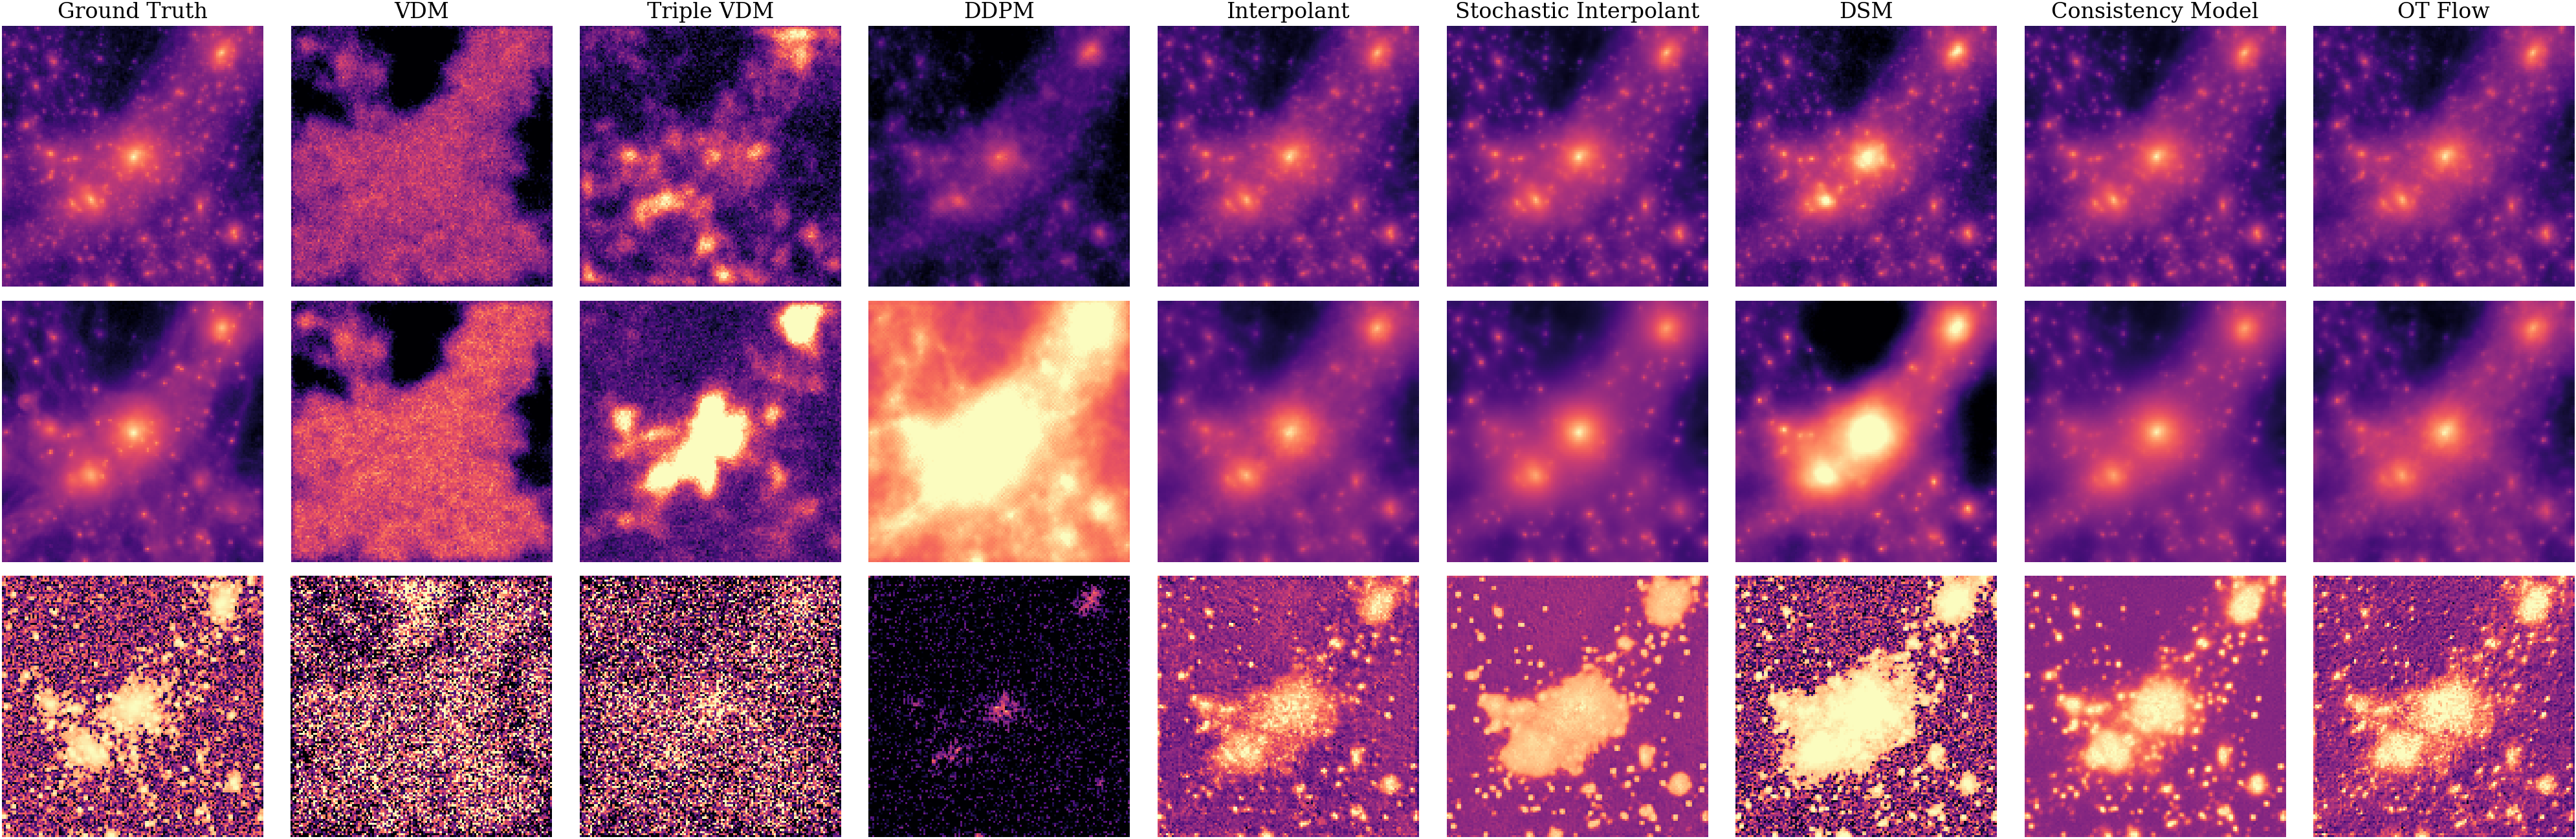

In [11]:
# Plot comparison: Ground Truth + each model
n_models = len(samples)
fig, axes = plt.subplots(3, n_models + 1, figsize=(3*(n_models+1), 9))

# Ground truth (first column)
for ch in range(3):
    im = axes[ch, 0].imshow(target[ch].numpy(), cmap='magma')
    axes[ch, 0].set_title('Ground Truth' if ch == 0 else '')
    axes[ch, 0].set_ylabel(CHANNEL_NAMES[ch])
    axes[ch, 0].axis('off')

# Model predictions
for col, (name, pred) in enumerate(samples.items(), 1):
    for ch in range(3):
        vmin, vmax = target[ch].numpy().min(), target[ch].numpy().max()
        axes[ch, col].imshow(pred[ch], cmap='magma', vmin=vmin, vmax=vmax)
        axes[ch, col].set_title(name if ch == 0 else '')
        axes[ch, col].axis('off')

plt.tight_layout()
plt.show()

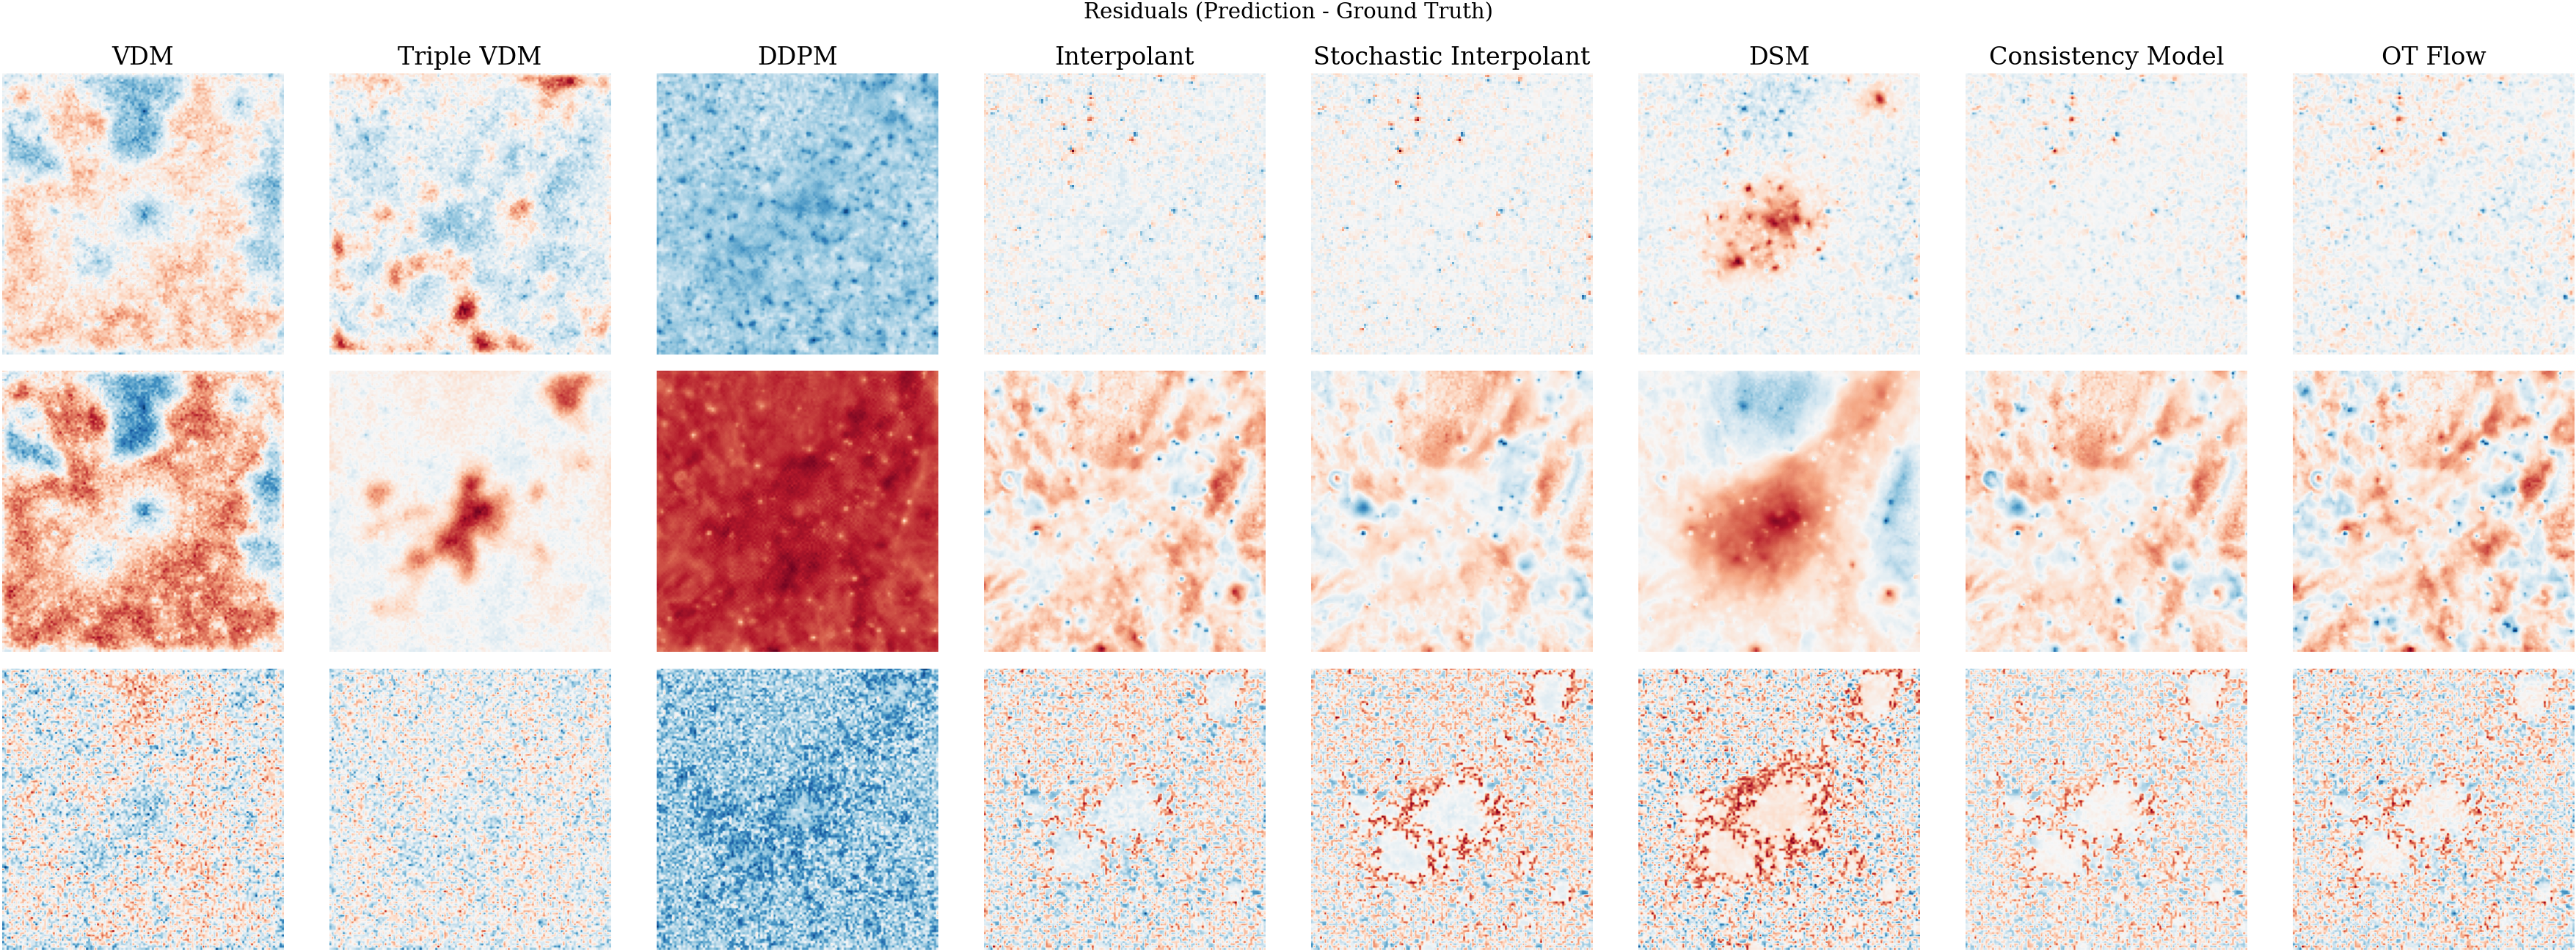

In [12]:
# Residuals (predicted - ground truth)
fig, axes = plt.subplots(3, n_models, figsize=(3*n_models, 9))
if n_models == 1:
    axes = axes[:, np.newaxis]

for col, (name, pred) in enumerate(samples.items()):
    for ch in range(3):
        residual = pred[ch] - target[ch].numpy()
        vlim = max(abs(residual.min()), abs(residual.max()))
        axes[ch, col].imshow(residual, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
        axes[ch, col].set_title(f'{name}' if ch == 0 else '')
        axes[ch, col].set_ylabel(CHANNEL_NAMES[ch] if col == 0 else '')
        axes[ch, col].axis('off')

plt.suptitle('Residuals (Prediction - Ground Truth)', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
# Quick metrics: MSE and correlation per channel
from scipy.stats import pearsonr

metrics = []
for name, pred in samples.items():
    for ch, ch_name in enumerate(CHANNEL_NAMES):
        gt = target[ch].numpy().flatten()
        pr = pred[ch].flatten()
        mse = np.mean((gt - pr)**2)
        corr, _ = pearsonr(gt, pr)
        metrics.append({'Model': name, 'Channel': ch_name, 'MSE': mse, 'Correlation': corr})

import pandas as pd
df = pd.DataFrame(metrics)
print(df.pivot(index='Model', columns='Channel', values='MSE').round(4))
print()
print(df.pivot(index='Model', columns='Channel', values='Correlation').round(4))

Channel                     Gas  Hydro DM   Stars
Model                                            
Consistency Model        0.0769    0.0214  0.0565
DDPM                    14.2716    1.3068  0.5476
DSM                      0.9588    0.0986  0.1098
Interpolant              0.0983    0.0271  0.0627
OT Flow                  0.0834    0.0273  0.0644
Stochastic Interpolant   0.0738    0.0221  0.0616
Triple VDM               3.0960    0.9600  0.2380
VDM                      2.3092    1.1404  0.2575

Channel                    Gas  Hydro DM   Stars
Model                                           
Consistency Model       0.9797    0.9900  0.5653
DDPM                    0.9498    0.9551  0.1253
DSM                     0.9596    0.9750  0.3991
Interpolant             0.9756    0.9881  0.4946
OT Flow                 0.9720    0.9875  0.5011
Stochastic Interpolant  0.9747    0.9898  0.5291
Triple VDM              0.8064    0.7170  0.1160
VDM                     0.7170    0.7234  0.0531


## 5. Training Loss Curves

Compare training progress across models using TensorBoard logs.

In [14]:
from tensorboard.backend.event_processing import event_accumulator
import glob

def load_tensorboard_scalars(log_dir, tags=None):
    """Load scalar metrics from TensorBoard logs."""
    ea = event_accumulator.EventAccumulator(str(log_dir))
    ea.Reload()
    
    available_tags = ea.Tags().get('scalars', [])
    if tags is None:
        tags = available_tags
    
    data = {}
    for tag in tags:
        if tag in available_tags:
            events = ea.Scalars(tag)
            data[tag] = {
                'steps': [e.step for e in events],
                'values': [e.value for e in events]
            }
    return data

# Model directories in tb_logs
TB_LOGS = Path('/mnt/home/mlee1/ceph/tb_logs3')
MODEL_DIRS = {
    'VDM': 'clean_vdm_aggressive_stellar',
    'Triple VDM': 'triple_vdm_separate_models',
    'DDPM': 'ddpm_ncsnpp_vp',
    'DSM': 'dsm_3ch',
    'Interpolant': 'interpolant_3ch',
    'OT Flow': 'ot_flow_3ch',
    'Consistency': 'consistency_3ch',
    'Stochastic Interp': 'stochastic_interpolant_3ch',
}

# Load training metrics for all models
training_data = {}
for name, model_dir in MODEL_DIRS.items():
    log_path = TB_LOGS / model_dir / 'version_0'
    if log_path.exists():
        try:
            # Load key metrics (use val/loss for models that have it, val/elbo for VDM)
            data = load_tensorboard_scalars(log_path)
            training_data[name] = data
            print(f"✓ Loaded {name}: {len(data)} metrics")
        except Exception as e:
            print(f"⚠️ Failed to load {name}: {e}")
    else:
        print(f"⚠️ {name}: log path not found")

✓ Loaded VDM: 57 metrics
✓ Loaded Triple VDM: 111 metrics
✓ Loaded DDPM: 12 metrics
✓ Loaded Triple VDM: 111 metrics
✓ Loaded DDPM: 12 metrics
✓ Loaded DSM: 20 metrics
✓ Loaded Interpolant: 12 metrics
✓ Loaded DSM: 20 metrics
✓ Loaded Interpolant: 12 metrics
✓ Loaded OT Flow: 16 metrics
✓ Loaded Consistency: 12 metrics
✓ Loaded OT Flow: 16 metrics
✓ Loaded Consistency: 12 metrics
✓ Loaded Stochastic Interp: 12 metrics
✓ Loaded Stochastic Interp: 12 metrics


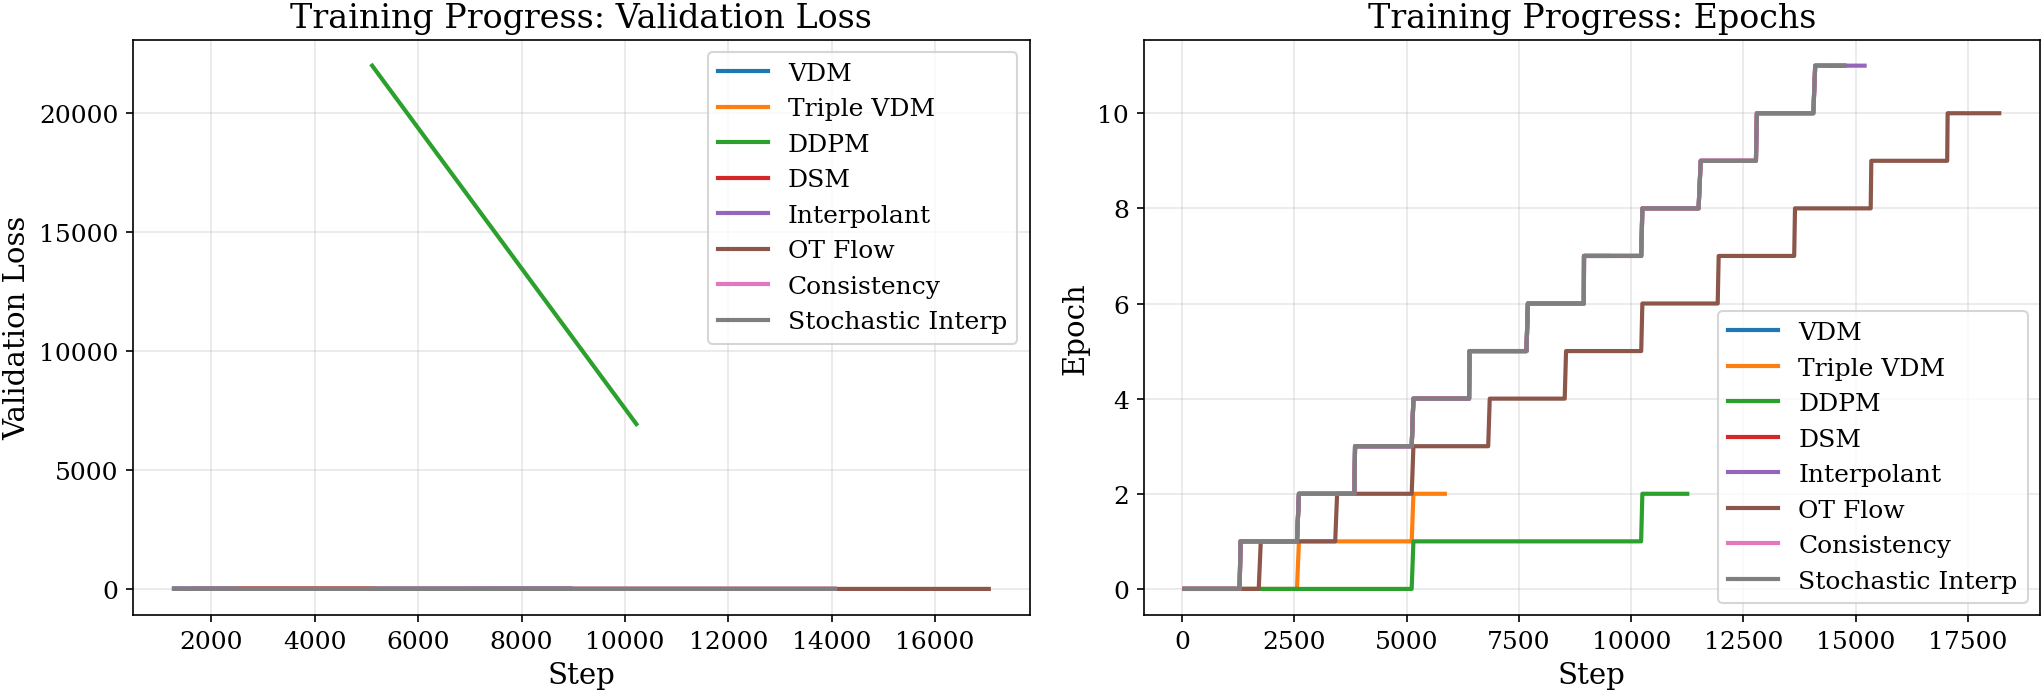

In [15]:
# Plot validation loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall validation loss
ax = axes[0]
for name, data in training_data.items():
    # Try different loss metric names
    for loss_key in ['val/elbo', 'val/loss', 'val/diffusion_loss']:
        if loss_key in data:
            steps = data[loss_key]['steps']
            values = data[loss_key]['values']
            ax.plot(steps, values, label=name, linewidth=2)
            break
ax.set_xlabel('Step')
ax.set_ylabel('Validation Loss')
ax.set_title('Training Progress: Validation Loss')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Right: Training speed (steps per time)
ax = axes[1]
for name, data in training_data.items():
    if 'epoch' in data:
        steps = data['epoch']['steps']
        epochs = data['epoch']['values']
        if len(steps) > 1:
            ax.plot(steps, epochs, label=name, linewidth=2)
ax.set_xlabel('Step')
ax.set_ylabel('Epoch')
ax.set_title('Training Progress: Epochs')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Summary table: final metrics for each model
summary_rows = []
for name, data in training_data.items():
    row = {'Model': name}
    
    # Get final validation loss
    for loss_key in ['val/elbo', 'val/loss', 'val/diffusion_loss']:
        if loss_key in data and data[loss_key]['values']:
            row['Final Val Loss'] = data[loss_key]['values'][-1]
            row['Best Val Loss'] = min(data[loss_key]['values'])
            break
    
    # Get final epoch
    if 'epoch' in data and data['epoch']['values']:
        row['Epochs'] = int(max(data['epoch']['values']))
    
    # Get final step
    for key in data:
        if data[key]['steps']:
            row['Steps'] = max(data[key]['steps'])
            break
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index('Model')
print("Training Summary:")
print(summary_df.round(4))

Training Summary:
                   Final Val Loss  Best Val Loss  Epochs  Steps
Model                                                          
VDM                       18.8336        12.8231       7      0
Triple VDM                20.5518        20.5518       2      0
DDPM                    6932.3711      6932.3711       2      0
DSM                        0.8977         0.8977      11      0
Interpolant                0.0910         0.0910      11      0
OT Flow                    0.0608         0.0608      10      0
Consistency                0.0038         0.0038      11      0
Stochastic Interp          0.0789         0.0789      11      0
